In [ ]:
#@title Imports and Dependencies

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
#@title Device Configuration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title Autoencoder Class Definition

class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, latent_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.Sigmoid()  # Sigmoid activation for output to be between 0 and 1
        )

    # Define forward pass as an encoding followed by decoding
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
#@title Hyperparameters Configuration

input_size = 784  #  28px x 28px = 784
latent_size = 3
batch_size = 64
learning_rate = 0.001
num_epochs = 20

In [ ]:
#@title Initialize Model, Loss Function, Optimizer

# Model
model = Autoencoder(input_size, latent_size).to(device)

# Loss Function
criterion = nn.MSELoss() # MSE is the standard reconstruction-oriented loss

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#@title MNIST Dataset Loading

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [ ]:
#@title DataLoaders for Training and Testing

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
#@title Autoencoder Training Loop

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)

        # Forward pass
        output = model(img)

        # Compute the loss
        loss = criterion(output, img)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for every epoch
    print(f'Epoch [{epoch+1:>2d}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [ 1/20], Loss: 0.0455
Epoch [ 2/20], Loss: 0.0368
Epoch [ 3/20], Loss: 0.0322
Epoch [ 4/20], Loss: 0.0381
Epoch [ 5/20], Loss: 0.0352
Epoch [ 6/20], Loss: 0.0327
Epoch [ 7/20], Loss: 0.0322
Epoch [ 8/20], Loss: 0.0354
Epoch [ 9/20], Loss: 0.0340
Epoch [10/20], Loss: 0.0319
Epoch [11/20], Loss: 0.0357
Epoch [12/20], Loss: 0.0303
Epoch [13/20], Loss: 0.0317
Epoch [14/20], Loss: 0.0355
Epoch [15/20], Loss: 0.0330
Epoch [16/20], Loss: 0.0270
Epoch [17/20], Loss: 0.0313
Epoch [18/20], Loss: 0.0370
Epoch [19/20], Loss: 0.0327
Epoch [20/20], Loss: 0.0276


In [ ]:
#@title Latent Space Encoding Function

def encode(loader):
  labels = []
  encoded = []
  with torch.no_grad():
      for data in loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)

        # Encode the input images
        encoded_imgs = model.encoder(img)

        # Store encoding on list along with it's labels
        for i in range(len(encoded_imgs)):
          labels.append(data[1][i].numpy())
          encoded.append(encoded_imgs[i].detach().numpy())

  # Make the list into an array
  encoded = np.array(encoded)
  labels = np.array(labels)

  return encoded, labels

In [ ]:
#@title Encode Training and Test Datasets

encoded_train, labels_train = encode(train_loader)
encoded_test, labels_test = encode(test_loader)

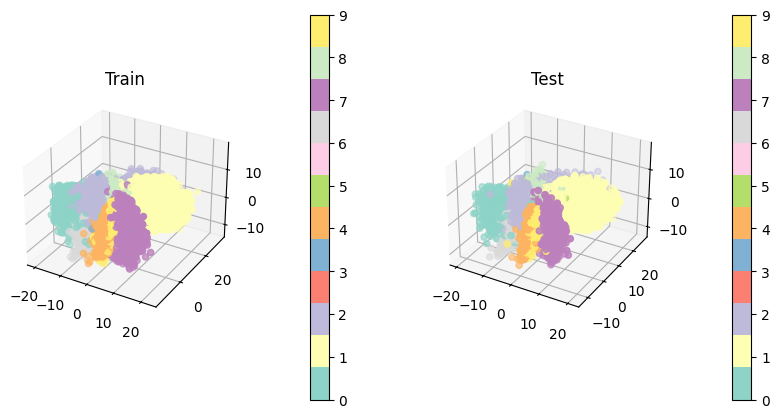

In [ ]:
#@title 3D Latent Space Visualization (Train vs Test)

# Create subplots
fig = plt.figure(figsize=(10, 5))

# Plot for train
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(encoded_train[:, 0], encoded_train[:, 1], encoded_train[:, 2], c=labels_train, cmap='Set3')
ax1.set_title('Train')
cbar1 = plt.colorbar(sc1, ax=ax1, pad=0.2)

# Plot for test
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(encoded_test[:, 0], encoded_test[:, 1], encoded_test[:, 2], c=labels_test, cmap='Set3')
ax2.set_title('Test')
cbar2 = plt.colorbar(sc2, ax=ax2, pad=0.2)

plt.show()

In [ ]:
#@title Random Sampling in Latent Space

# Generating random values within the specified ranges for each column
first_two_columns = torch.FloatTensor(9, 2).uniform_(-20, 10)
last_column = torch.FloatTensor(9, 1).uniform_(-10, 20)

# Concatenating the columns to create the desired tensor
random_points = torch.cat((first_two_columns, last_column), dim=1)

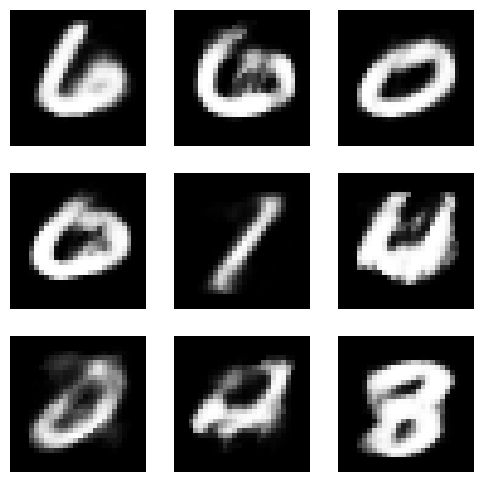

In [ ]:
#@title Decode Random Latent Points to Images

# Pass the random vector through the decoder
decoded_output = model.decoder(random_points).detach().numpy()

# Plotting the images in subplots
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    # Reshape the array to 28x28
    image = decoded_output[i].reshape(28, 28)

    # Display the image in grayscale
    ax.imshow(image, cmap='gray')
    ax.axis('off')  # Turn off axis labels

plt.show()